In [1]:
import data_loader as dl
import data_visualizer as dv 
import numpy as np
import pandas as pd
import logging
import os
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from match_predictor import predict_match_outcome
from adaboost_module import adaboost_model
from lightgbm_module import lightgbm_train_model
from extratrees_module import train_et_model
from xgb_model import xgboost_model
from sklearn.ensemble import AdaBoostClassifier
from gradient_boosting_module import train_and_prepare_model


logging.basicConfig(filename='log.log', level=logging.INFO, format="%(asctime)s %(levelname)s %(module)s %(message)s")
logger = logging.getLogger(__name__)
# Загрузка данных

file_csv = 'results.csv'

try:
    loader = dl.DataLoader()
    df = loader.load_csv(file_csv)
except Exception as e:
    logger.exception(f"Ошибка при загрузке CSV: {e}")    

# Из-за огромного количества записей выбераю только данные с 2015 года 
df['year'] = df['date'].str[:4].astype(int)
df_filtered = df[df['year'] >= 2015]
df_filtered = df_filtered.drop(columns=['year'])

    # Добавляем новые признаки
df_filtered['home_team_avg_goals'] = df_filtered.groupby('home_team')['home_score'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df_filtered['away_team_avg_goals'] = df_filtered.groupby('away_team')['away_score'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df_filtered['home_team_avg_goals_10'] = df_filtered.groupby('home_team')['home_score'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df_filtered['away_team_avg_goals_10'] = df_filtered.groupby('away_team')['away_score'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df_filtered['outcome'] = df.apply(
    lambda row: 'home_win' if row['home_score'] > row['away_score'] else
                'draw' if row['home_score'] == row['away_score'] else
                'away_win', axis=1
)

# Добавляем новые признаки: победы и поражения за последние 5 матчей
# Для домашней команды
df_filtered['home_team_wins'] = df_filtered.groupby('home_team')['outcome'].transform(
    lambda x: (x == 'home_win').rolling(window=5, min_periods=1).sum()
)
df_filtered['home_team_losses'] = df_filtered.groupby('home_team')['outcome'].transform(
    lambda x: (x == 'away_win').rolling(window=5, min_periods=1).sum()
)

# Для гостевой команды
df_filtered['away_team_wins'] = df_filtered.groupby('away_team')['outcome'].transform(
    lambda x: (x == 'away_win').rolling(window=5, min_periods=1).sum()
)
df_filtered['away_team_losses'] = df_filtered.groupby('away_team')['outcome'].transform(
    lambda x: (x == 'home_win').rolling(window=5, min_periods=1).sum()
)

# Добавляем колонку с результатами последних 5 матчей между командами
df_filtered['last_5_results'] = None

for i, row in df_filtered.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    date = row['date']

    # Находим последние 5 матчей между этими командами до текущей даты
    matches = df_filtered[
        (
            (df_filtered['home_team'] == home_team) & (df_filtered['away_team'] == away_team)
        ) | (
            (df_filtered['home_team'] == away_team) & (df_filtered['away_team'] == home_team) & (df_filtered['date'] < date)
        )
    ].sort_values(by='date', ascending=False).head(5)

    # Собираем результаты матчей
    results = []
    for _, match in matches.iterrows():
        if match['home_team'] == home_team:
            results.append(match['outcome'])
        else:
            # Если команды поменялись местами, инвертируем результат
            if match['outcome'] == 'home_win':
                results.append('away_win')
            elif match['outcome'] == 'away_win':
                results.append('home_win')
            else:
                results.append('draw')

    # Сохраняем результаты в виде строки
    df_filtered.at[i, 'last_5_results'] = ','.join(results)

# Преобразуем last_5_results в числовые признаки
df_filtered['last_5_home_wins'] = df_filtered['last_5_results'].apply(lambda x: x.count('home_win'))
df_filtered['last_5_away_wins'] = df_filtered['last_5_results'].apply(lambda x: x.count('away_win'))
df_filtered['last_5_draws'] = df_filtered['last_5_results'].apply(lambda x: x.count('draw'))

df_filtered_pr = df_filtered.copy() #какая-то ерунда с датасетом происходит на момент обучения модели, создал отдельный датасет который буду только для прогнозов использовать

output_file = 'filtered_results.xlsx'

try:
    df_filtered.to_excel(output_file, index=False)  # index=False, чтобы не сохранять индексы
    logger.info(f"Датасет успешно сохранен в файл: {output_file}")
except Exception as e:
    logger.exception(f"Ошибка при сохранении Excel: {e}")



In [2]:
df_filtered.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_avg_goals,...,away_team_avg_goals_10,outcome,home_team_wins,home_team_losses,away_team_wins,away_team_losses,last_5_results,last_5_home_wins,last_5_away_wins,last_5_draws
38370,2015-01-04,Bahrain,Jordan,1,0,Friendly,Ballarat,Australia,True,1.0,...,0.0,home_win,1.0,0.0,0.0,1.0,"away_win,away_win,draw,draw,home_win",1,2,2
38371,2015-01-04,Iran,Iraq,1,0,Friendly,Wollongong,Australia,True,1.0,...,0.0,home_win,1.0,0.0,0.0,1.0,"home_win,home_win,draw,away_win,draw",2,1,2
38372,2015-01-04,South Korea,Saudi Arabia,2,0,Friendly,Parramatta,Australia,True,2.0,...,0.0,home_win,1.0,0.0,0.0,1.0,"home_win,draw,home_win",2,0,1
38373,2015-01-04,South Africa,Zambia,1,0,Friendly,Johannesburg,South Africa,False,1.0,...,0.0,home_win,1.0,0.0,0.0,1.0,"away_win,draw,away_win,away_win,home_win",1,3,1
38374,2015-01-05,China PR,Oman,4,1,Friendly,Penrith,Australia,True,4.0,...,1.0,home_win,1.0,0.0,0.0,1.0,"draw,home_win",1,0,1


In [3]:
df_filtered.describe()

,home_score,away_score,home_team_avg_goals,away_team_avg_goals,home_team_avg_goals_10,away_team_avg_goals_10,home_team_wins,home_team_losses,away_team_wins,away_team_losses,last_5_home_wins,last_5_away_wins,last_5_draws
count,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000,9610.000000
mean,1.608949,1.106764,1.608314,1.104858,1.609354,1.104071,2.257544,1.363163,1.381374,2.243600,1.162331,0.827784,0.641415
std,1.635490,1.303887,0.908264,0.729839,0.776783,0.636864,1.311254,1.182862,1.129702,1.315894,1.144688,1.022791,0.837034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.600000,1.100000,0.700000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.400000,1.000000,1.500000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000
75%,2.000000,2.000000,2.000000,1.400000,2.000000,1.400000,3.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000
max,15.000000,14.000000,9.000000,12.000000,9.000000,12.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [4]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9610 entries, 38370 to 47979
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    9610 non-null   object 
 1   home_team               9610 non-null   object 
 2   away_team               9610 non-null   object 
 3   home_score              9610 non-null   int64  
 4   away_score              9610 non-null   int64  
 5   tournament              9610 non-null   object 
 6   city                    9610 non-null   object 
 7   country                 9610 non-null   object 
 8   neutral                 9610 non-null   bool   
 9   home_team_avg_goals     9610 non-null   float64
 10  away_team_avg_goals     9610 non-null   float64
 11  home_team_avg_goals_10  9610 non-null   float64
 12  away_team_avg_goals_10  9610 non-null   float64
 13  outcome                 9610 non-null   object 
 14  home_team_wins          9610 non-null   

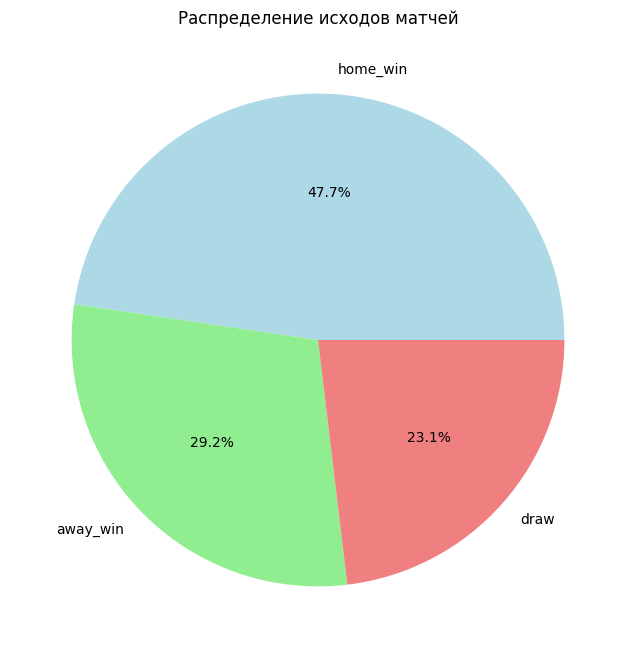

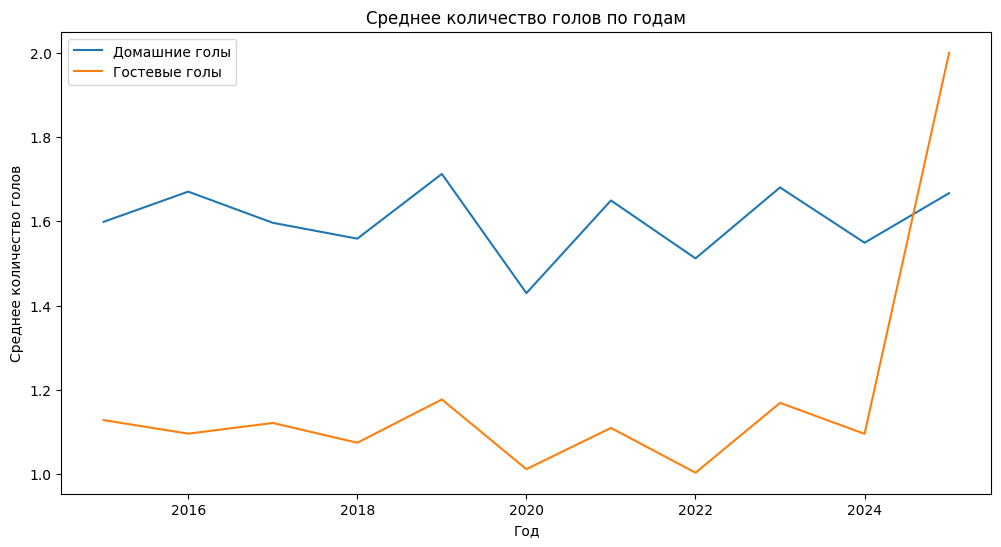

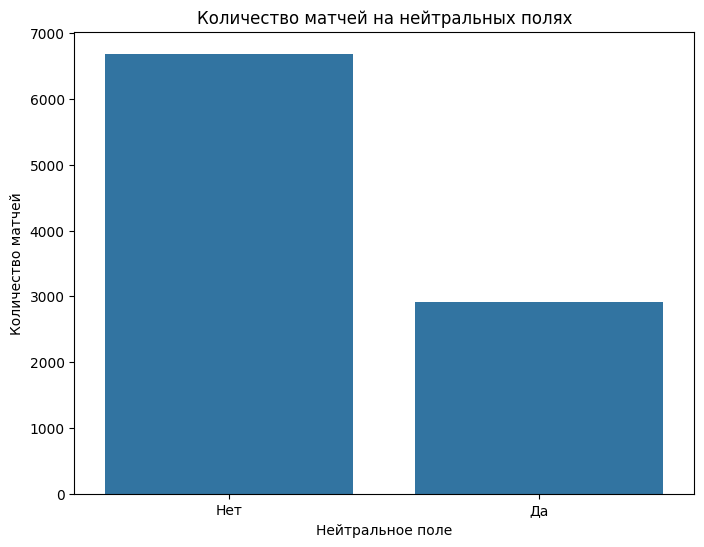

In [5]:
visualizer = dv.DataVisualizer(df_filtered)

# Вызов функций для визуализации
visualizer.plot_match_outcomes(home_score_col='home_score', away_score_col='away_score')
visualizer.plot_goals_by_year(date_col='date', home_score_col='home_score', away_score_col='away_score')
visualizer.plot_matches_by_country(country_col='country')
visualizer.plot_neutral_fields(neutral_col='neutral')

In [6]:
#Классификатор градиентного бустинг
try:
    model, label_encoders = train_and_prepare_model(df_filtered)
except Exception as e:
    logger.exception(f"Ошибка обучения модели: {e}") 
  
 

Gradient Boosting Accuracy: 0.88
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

    away_win       0.88      0.88      0.88       540
        draw       0.77      0.89      0.83       433
    home_win       0.95      0.88      0.92       949

    accuracy                           0.88      1922
   macro avg       0.87      0.88      0.87      1922
weighted avg       0.89      0.88      0.89      1922



In [7]:
# Пример данных для предсказания использую будущий матч Классификатор градиентного бустинг
date = '2025-03-20'
home_team = 'Turkey'
away_team = 'Hungary'
home_score = None  
away_score = None  
tournament = 'UEFA Nations League'
city = 'Istanbul'
country = 'Turkey'
neutral = False

try:
    result = predict_match_outcome(date, home_team, away_team, home_score, away_score, tournament, city, country, neutral, model, label_encoders, df_filtered_pr)
    print(f"Предсказанный исход матча {home_team} vs {away_team}: {result}")
except Exception as e:
    logger.exception(f"Ошибка моделирования предсказания матча: {e}") 

Предсказанный исход матча Turkey vs Hungary: Победа гостевой команды


In [8]:
#AdaBoost
try:
    ada_model, label_encoders = adaboost_model(df_filtered)
except Exception as e:
    logger.exception(f"Ошибка обучения модели: {e}") 

AdaBoost Accuracy: 0.88
AdaBoost Classification Report:
              precision    recall  f1-score   support

    away_win       0.87      0.89      0.88       540
        draw       0.79      0.84      0.82       433
    home_win       0.93      0.90      0.92       949

    accuracy                           0.88      1922
   macro avg       0.87      0.88      0.87      1922
weighted avg       0.88      0.88      0.88      1922



In [9]:
# Пример данных для предсказания использую будущий матч AdaBoost
date = '2025-03-20'
home_team = 'Turkey'
away_team = 'Hungary'
home_score = None  
away_score = None  
tournament = 'UEFA Nations League'
city = 'Istanbul'
country = 'Turkey'
neutral = False

try:
    result = predict_match_outcome(date, home_team, away_team, home_score, away_score, tournament, city, country, neutral, ada_model, label_encoders, df_filtered_pr)
    print(f"Предсказанный исход матча {home_team} vs {away_team}: {result}")
except Exception as e:
    logger.exception(f"Ошибка моделирования предсказания матча: {e}") 

Предсказанный исход матча Turkey vs Hungary: Победа гостевой команды


In [10]:
#LightGBM
try:
    model_tm, label_encoders = lightgbm_train_model(df_filtered)
except Exception as e:
    logger.exception(f"Ошибка обучения модели: {e}") 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1349
[LightGBM] [Info] Number of data points in the train set: 7688, number of used features: 17
[LightGBM] [Info] Start training from score -1.220762
[LightGBM] [Info] Start training from score -1.459122
[LightGBM] [Info] Start training from score -0.749602
Accuracy: 0.89
LightGBM Classification Report:
              precision    recall  f1-score   support

    away_win       0.89      0.89      0.89       540
        draw       0.82      0.82      0.82       433
    home_win       0.92      0.92      0.92       949

    accuracy                           0.89      1922
   macro avg       0.88      0.88      0.88      1922
weighted avg       0.89      0.89      0.89      1922



In [11]:
# Пример данных для предсказания использую будущий матч LightGBM
date = '2025-03-20'
home_team = 'Turkey'
away_team = 'Hungary'
home_score = None  
away_score = None  
tournament = 'UEFA Nations League'
city = 'Istanbul'
country = 'Turkey'
neutral = False

try:
    result = predict_match_outcome(date, home_team, away_team, home_score, away_score, tournament, city, country, neutral, model_tm, label_encoders, df_filtered_pr)
    print(f"Предсказанный исход матча {home_team} vs {away_team}: {result}")
except Exception as e:
    logger.exception(f"Ошибка моделирования предсказания матча: {e}") 

Предсказанный исход матча Turkey vs Hungary: Победа гостевой команды


In [12]:
#Extra Trees
try:
    model_ets, label_encoders = train_et_model(df_filtered)
except Exception as e:
    logger.exception(f"Ошибка обучения модели: {e}") 

Extra Trees Accuracy: 0.89
Extra Trees Classification Report:
              precision    recall  f1-score   support

    away_win       0.89      0.89      0.89       540
        draw       0.83      0.82      0.82       433
    home_win       0.92      0.92      0.92       949

    accuracy                           0.89      1922
   macro avg       0.88      0.88      0.88      1922
weighted avg       0.89      0.89      0.89      1922



In [13]:
# Пример данных для предсказания использую будущий матч Extra Trees
date = '2025-03-20'
home_team = 'Turkey'
away_team = 'Hungary'
home_score = None  
away_score = None  
tournament = 'UEFA Nations League'
city = 'Istanbul'
country = 'Turkey'
neutral = False

try:
    result = predict_match_outcome(date, home_team, away_team, home_score, away_score, tournament, city, country, neutral, model_ets, label_encoders, df_filtered_pr)
    print(f"Предсказанный исход матча {home_team} vs {away_team}: {result}")
except Exception as e:
    logger.exception(f"Ошибка моделирования предсказания матча: {e}") 

Предсказанный исход матча Turkey vs Hungary: Победа гостевой команды


In [14]:
#XGBoost
try:
    model_xgb, label_encoders = xgboost_model(df_filtered)
except Exception as e:
    logger.exception(f"Ошибка обучения модели: {e}") 

XGBoost Accuracy: 0.88
XGBoost Classification Report:
              precision    recall  f1-score   support

    away_win       0.88      0.88      0.88       540
        draw       0.78      0.86      0.82       433
    home_win       0.94      0.89      0.91       949

    accuracy                           0.88      1922
   macro avg       0.87      0.88      0.87      1922
weighted avg       0.89      0.88      0.88      1922



In [15]:
# Пример данных для предсказания использую будущий матч XGBoost
date = '2025-03-20'
home_team = 'Turkey'
away_team = 'Hungary'
home_score = None  
away_score = None  
tournament = 'UEFA Nations League'
city = 'Istanbul'
country = 'Turkey'
neutral = False


result = predict_match_outcome(date, home_team, away_team, home_score, away_score, tournament, city, country, neutral, model_xgb, label_encoders, df_filtered)
print(f"Предсказанный исход матча {home_team} vs {away_team}: {result}")

Предсказанный исход матча Turkey vs Hungary: Ничья


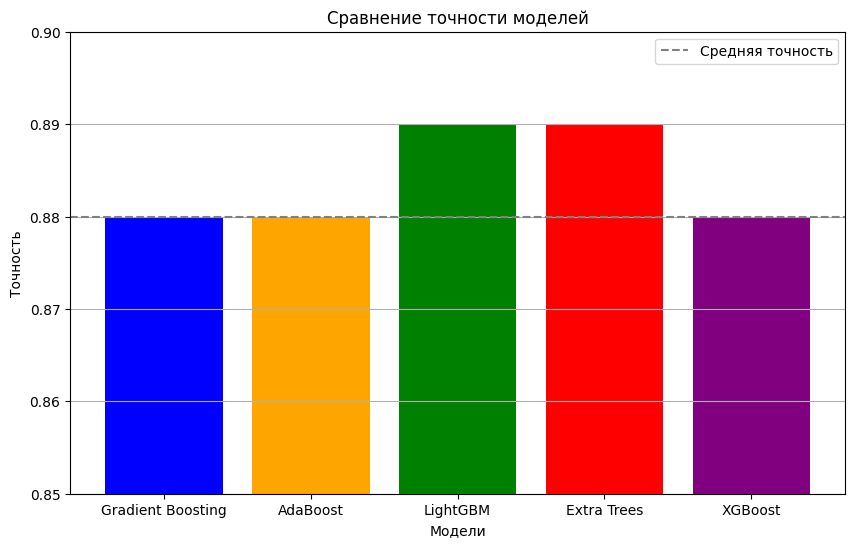

In [16]:
models = [
    "Gradient Boosting",
    "AdaBoost",
    "LightGBM",
    "Extra Trees",
    "XGBoost"
]

accuracies = [0.88, 0.88, 0.89, 0.89, 0.88]  # Точности моделей

visualizer.plot_model_accuracy(models, accuracies) 